In [1]:
from numpy import linspace, sin, cos, pi
from numpy import array, concatenate, where, interp

In [2]:
from scipy.signal import hilbert

In [3]:
from ipywidgets import interact

# Secuencia de rango

* Determinación de orbita

La secuencia de rango tiene como objetivo principal la medición de la distancia del centro de control, necesaria para la **determinación de orbita**.

# Parametros del sistema

$$
\omega_M = 27777.78
$$

$$
\begin{align}
\omega_1 &= 22222.2 \\
\omega_2 &= 23333.33 \\
\omega_3 &= 22444.44 \\
\omega_4 &= 22266.67 \\
\omega_5 &= 22231.11 \\
\omega_6 &= 22224.00
\end{align}
$$

El sistema de rango utiliza una secuencia de tipo ESA Like, compuesta de 1 tono mayor y 6 tonos menores, los cuales se encuentran entre los $22 KHz$ y $28 KHz$.

![](./diagrams/range_sequence.png)

* En primer lugar se recibe una petición para medición de rango y se genera una señal con el tono mayor por $T_a$
* En segundo, se añade un tono menor a la señal de mayor para crear el tono virtual necesario por $T$ segundos
* En tercero, se tomo un tiempo $IT$ de a lo menos 250ms para la medición del desfasamiento del tono virtual
* Se repite este proceso para el resto de los tonos menores
* Despues de lo cual, se queda el tono mayor solamente por $T_s$ segundos
* Y se procede a tomar $10$ mediciones, una cada $250ms$

In [4]:
ωm = 27777.78
ωs = [22222.22, 23333.33, 22444.44, 22266.67, 22231.11, 22224.00]

In [5]:
Ta = Ts = 2
T = IT = 2

T0 = 0
Tf = Ta + 6*(T + IT) + Ts + 10*0.25

δt = 0.000003
n = int(Tf/δt) + 1

ts = linspace(T0, Tf+1, n)

tm = linspace(T0, Ta - δt, int(Ta/δt))
t1 = linspace(Ta + 0*(T + IT), Ta + 1*(T + IT) - δt, int((T + IT)/δt))
t2 = linspace(Ta + 1*(T + IT), Ta + 2*(T + IT) - δt, int((T + IT)/δt))
t3 = linspace(Ta + 2*(T + IT), Ta + 3*(T + IT) - δt, int((T + IT)/δt))
t4 = linspace(Ta + 3*(T + IT), Ta + 4*(T + IT) - δt, int((T + IT)/δt))
t5 = linspace(Ta + 4*(T + IT), Ta + 5*(T + IT) - δt, int((T + IT)/δt))
t6 = linspace(Ta + 5*(T + IT), Ta + 6*(T + IT) - δt, int((T + IT)/δt))
tw = linspace(Ta + 6*(T + IT), Ta + 6*(T + IT) + Ts - δt, int(Ts/δt))
tmeas = linspace(Ta + 6*(T + IT) + Ts, Tf, int(10*0.25/δt))
tsil = linspace(Tf, Tf + 1, int(1/δt) + 1)

In [6]:
maj_ton = lambda ts: sin(2*pi*ωm*ts)
tone1   = lambda ts: sin(2*pi*ωs[0]*ts)
tone2   = lambda ts: sin(2*pi*ωs[1]*ts)
tone3   = lambda ts: sin(2*pi*ωs[2]*ts)
tone4   = lambda ts: sin(2*pi*ωs[3]*ts)
tone5   = lambda ts: sin(2*pi*ωs[4]*ts)
tone6   = lambda ts: sin(2*pi*ωs[5]*ts)

sm = maj_ton(tm)
s1 = maj_ton(t1) + tone1(t1)
s2 = tone1(t2) + tone2(t2)
s3 = tone1(t3) + tone3(t3)
s4 = tone1(t4) + tone4(t4)
s5 = tone1(t5) + tone5(t5)
s6 = tone1(t6) + tone6(t6)
sw = maj_ton(tw)
smeas = maj_ton(tmeas)
ssil = array([0 for t in tsil])

In [7]:
from matplotlib.pyplot import figure, rcParams, subplot2grid
from conf_matplotlib import conf_matplotlib_claro
conf_matplotlib_claro()

cycle = rcParams['axes.prop_cycle'].by_key()['color']
colores = [tuple(int(h.lstrip('#')[i:i+2], 16) for i in (0, 2, 4)) for h in cycle]

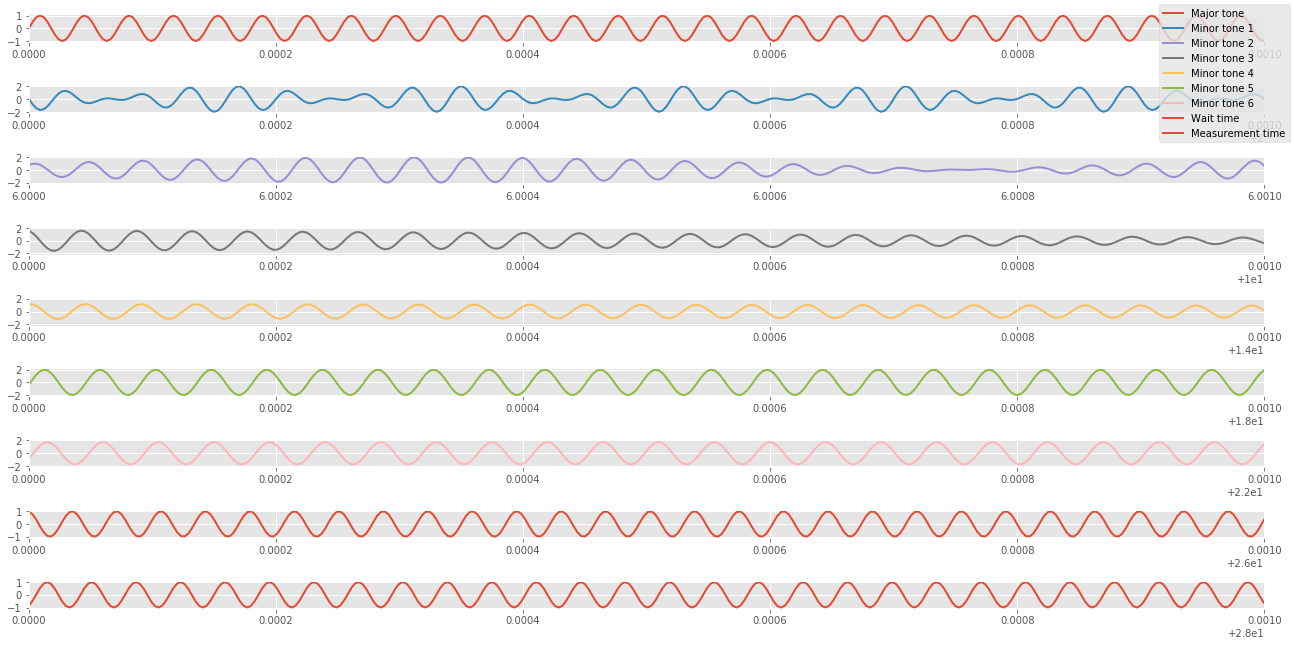

In [39]:
fig = figure(figsize=(18,9))
axm, ax1, ax2, ax3, ax4, ax5, ax6, axw, axmeas = fig.subplots(9, 1, gridspec_kw={'height_ratios': [1,1,1,1,1,1,1,1,1]})

axm.plot(tm, sm, c=cycle[0], label=r"Major tone")
ax1.plot(t1, s1, c=cycle[1], label=r"Minor tone 1")
ax2.plot(t2, s2, c=cycle[2], label=r"Minor tone 2")
ax3.plot(t3, s3, c=cycle[3], label=r"Minor tone 3")
ax4.plot(t4, s4, c=cycle[4], label=r"Minor tone 4")
ax5.plot(t5, s5, c=cycle[5], label=r"Minor tone 5")
ax6.plot(t6, s6, c=cycle[6], label=r"Minor tone 6")
axw.plot(tw, sw, c=cycle[0], label=r"Wait time")
axmeas.plot(tmeas, smeas, c=cycle[0], label=r"Measurement time")

axm.set_xlim(tm[0], tm[0] + 0.001)
ax1.set_xlim(t1[0], t1[0] + 0.001)
ax2.set_xlim(t2[0], t2[0] + 0.001)
ax3.set_xlim(t3[0], t3[0] + 0.001)
ax4.set_xlim(t4[0], t4[0] + 0.001)
ax5.set_xlim(t5[0], t5[0] + 0.001)
ax6.set_xlim(t6[0], t6[0] + 0.001)
axw.set_xlim(tw[0], tw[0] + 0.001)
axmeas.set_xlim(tmeas[0], tmeas[0] + 0.001)

fig.legend()
fig.tight_layout();
fig.savefig("muestras-sec-rango.pdf")

Estos tonos son enviados de acuerdo a la secuencia de la figura anterior, primero el major tone, despues los minor tones en combinación, seguido de un periodo para la estabilización del PLL y por ultimo las $10$ mediciones de rango que vemos en archivos y event viewer con el major tone solamente.

![](./muestras-sec-rango.svg)

In [9]:
ts = concatenate([tm, t1, t2, t3, t4, t5, t6, tw, tmeas, tsil])
ss = concatenate([sm, s1, s2, s3, s4, s5, s6, sw, smeas, ssil])

## Efectos internos

Existen factores que estan involucrados con el tiempo medido por el sistema de rango, es facil dividirlos como internos y externos.

* Retraso en equipo de tierra

Un factor interno es el retraso en el equipo de tierra, el cual esta considerado en los archivos de calibración, por lo que es importante tener en cuenta que este debe coincidir con la cadena de RF utilizada actualmente.

* Amplificación en nave

El retardo en el equipo de retransmisión de la nave es siempre el mismo, siempre y cuando la configuración de enrutamiento de rango sea el adecuado. Si se configura la transmisión de comandos y rango por la frecuencia asociada al CMR2, es necesario que tambien se configure la ruta para la señal de rango del CMR2 al TTX1 en caso de tener el transmisor de telemetria 1.

## Efectos externos

* Distancia del centro de control al satelite

La distancia del centro de control al satelite es variable y es justamente el parametro a medir para una adecuada determinación de orbita. Para la simulación actual se utiliza el valor $\rho = 36,480.152km$.

In [10]:
from scipy.constants import c

distancia_ant_sat = 36.480152e6
delay = 2*distancia_ant_sat/c
delay

0.24336937789142113

* Efectos de atenuación por fenomenos atmosféricos

In [11]:
top = concatenate([array([0, ts[0] - δt]), array([t + delay for t in ts])])
sop = concatenate([array([0, 0]), ss])

to = ts
so = array([interp(t, top, sop) for t in to])

Los efectos de atenuación por fenomenos atmosféricos (clima) no son considerados dentro de esta simulación debido a que tomaria demasiado tiempo hacer un algoritmo robusto para enfrentar estos efectos, sin embargo se puede comentar que estos efectos son compensados en menor medida por la amplificación de la señal repetida por la nave, y en mayor medida por el PLL interno al cortex de la BBU en tierra.

## Tonos virtuales

In [12]:
hss = abs(hilbert(ss))
hso = abs(hilbert(so))

In [13]:
ωsv = [5555.56, 1111.11, 222.22, 44.44, 8.89, 1.78]

In [14]:
def tono1_virtual(α = 1):
    fig = figure(figsize=(18,4))
    ax = fig.gca()
    ax.plot(ts, ss, lw=2, c=cycle[0], alpha=α)
    ax.plot(ts, hss, "--", lw=2, c=cycle[0], alpha=1-α)
    ax.plot(to, so, lw=2, c=cycle[1], alpha=α)
    ax.plot(to, hso, "--", lw=2, c=cycle[1], alpha=1-α)
    ax.set_xlim(t1[0] + 0.25, t1[0] + 0.25 + 2/ωsv[0]);

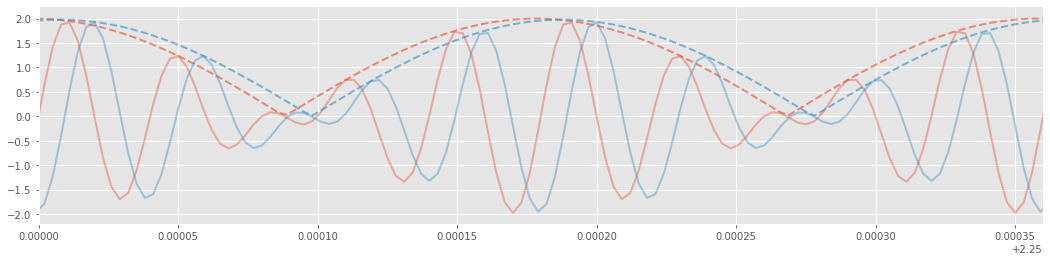

In [36]:
tono1_virtual(α=0.4)

La transmisión de los minor tones anteriores a las mediciones de rango, se hacen en conjunto, de tal manera que se crea interferencia constructiva y destructiva (modulación), en la señal final de los minor tones y se cree un tono virtual, equivalente a la diferencia de las frecuencias de los minor tones.

In [16]:
ωsv = [5555.56, 1111.11, 222.22, 44.44, 8.89, 1.78]

In [17]:
def grafica_liss_sen(periodo="Minor tone 1"):
    from numpy import arcsin, degrees
    
    options = {"Major tone": tm,
               "Minor tone 1": t1,
               "Minor tone 2": t2,
               "Minor tone 3": t3,
               "Minor tone 4": t4,
               "Minor tone 5": t5,
               "Minor tone 6": t6,
               "Waiting time": tw,
               "Measurement time": tmeas}
    
    tspans  = {"Major tone": 1.2/ωm,
               "Minor tone 1": 1.2/ωsv[0],
               "Minor tone 2": 1.2/ωsv[1],
               "Minor tone 3": 1.2/ωsv[2],
               "Minor tone 4": 1.2/ωsv[3],
               "Minor tone 5": 1.2/ωsv[4],
               "Minor tone 6": 1.2/ωsv[5],
               "Waiting time": 1.2/ωm,
               "Measurement time": 1.2/ωm}
    
    per = options[periodo]
    Δt = tspans[periodo]
    
    t0 = per[0] + 0.25
    tf = t0 + Δt
    ind_ini = where(ts <= t0)[0][-1]
    ind_fin = where(ts <= tf)[0][-1]

    fig = figure(figsize=(20, 5))
    ax1 = subplot2grid((1,4), (0,0))
    ax2 = subplot2grid((1,4), (0,1), colspan=3)
    
    if periodo[0:5] == "Minor":
        ind_cur1 = where(hss == max(hss[ind_ini:ind_fin]))[0][0]
        ind_cur2 = where(hso == max(hso[ind_ini:ind_fin]))[0][0]
        t_cur1 = ts[ind_cur1]
        t_cur2 = ts[ind_cur2]
        
        ax1.plot(hss[ind_ini:ind_fin], hso[ind_ini:ind_fin], lw=2, c=cycle[3])
        ax1.plot(hss[ind_cur1], hso[ind_cur1], "o", c=cycle[2])
        ax1.plot(hss[ind_cur2], hso[ind_cur2], "o", c=cycle[4])
        
        ax2.plot(ts, ss, lw=2, c=cycle[0], alpha=0.3)
        ax2.plot(ts, hss, "--", lw=2, c=cycle[0])
        ax2.plot(to, so, lw=2, c=cycle[1], alpha=0.3)
        ax2.plot(to, hso, "--", lw=2, c=cycle[1])
    else:
        ind_cur1 = where(ss == max(ss[ind_ini:ind_fin]))[0][0]
        ind_cur2 = where(so == max(so[ind_ini:ind_fin]))[0][0]
        t_cur1 = ts[ind_cur1]
        t_cur2 = ts[ind_cur2]
        
        ax1.plot(ss[ind_ini:ind_fin], so[ind_ini:ind_fin], lw=2, c=cycle[3])
        ax1.plot(ss[ind_cur1], so[ind_cur1], "o", c=cycle[2])
        ax1.plot(ss[ind_cur2], so[ind_cur2], "o", c=cycle[4])
        
        ax2.plot(ts, ss, lw=2, c=cycle[0])
        ax2.plot(to, so, lw=2, c=cycle[1])
        
    ax2.axvline(x=t_cur1, lw=2, c=cycle[2])
    ax2.axvline(x=t_cur2, lw=2, c=cycle[4])

    ax2.set_xlim(t0, tf);
    ϕt = t_cur2 - t_cur1
    #print(f"T = {(T + Δt/2.4)%(Δt/2.4)}")
    print(f"T = {ϕt}")

In [18]:
options = ["Major tone",
           "Minor tone 1",
           "Minor tone 2",
           "Minor tone 3",
           "Minor tone 4",
           "Minor tone 5",
           "Minor tone 6",
           "Waiting time",
           "Measurement time"]

Estas frecuencias de los tonos virtuales, son las que nos dan menor ambiguedad en la medición.

T = 9.00000225012576e-06


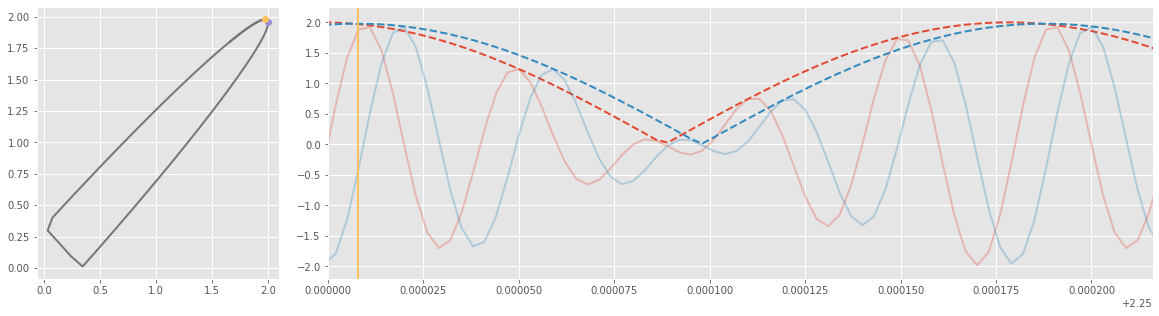

In [37]:
grafica_liss_sen()

En cada uno de las transmisiones de los minor tones, se esperan $250ms$ para esperar la señal de regreso del satelite y poder empezar a medir el desfasamiento de esta señal, en esta simulación se trabaja con la transformación de Hilbert para calcular la envolvente de la señal de salida y la de regreso, en la vida real el PLL de la BBU se encarga de la medición del desfasamiento en tiempo real.

In [20]:
def desfasamientos(t0, tf, ω):
    ind_ini = where(ts <= t0)[0][-1]
    ind_fin = where(ts <= tf)[0][-1]
    
    ind_cur1 = where(hss == max(hss[ind_ini:ind_fin]))[0][0]
    ind_cur2 = where(hso == max(hso[ind_ini:ind_fin]))[0][0]
    
    t_cur1 = ts[ind_cur1]
    t_cur2 = ts[ind_cur2]
    
    ϕt = t_cur2 - t_cur1
    
    return ϕt

t0s = [t1[0]+0.25, t2[0]+0.25, t3[0]+0.25, t4[0]+0.25, t5[0]+0.25, t6[0]+0.25]
tfs = [t + (1.2/ω)*5 for t, ω in zip(*[t0s, ωsv])]

ϕts = [desfasamientos(t0, tf, ω) for t0, tf, ω in zip(*[t0s, tfs, ωsv])]

In [21]:
ϕts

[9.00000225012576e-06,
 0.0003690000922498271,
 -0.022143005535756544,
 -0.09408602352152329,
 0.018417004604255993,
 0.24336906084231202]

In [22]:
Tvs = [1/ω for ω in ωsv]
Tvs

[0.0001799998560001152,
 0.0009000009000009001,
 0.004500045000450005,
 0.022502250225022502,
 0.11248593925759279,
 0.5617977528089888]

In [23]:
delays = [ϕ%t for ϕ, t in zip(*[ϕts, Tvs])]
delays

[9.00000225012576e-06,
 0.0003690000922498271,
 0.00035721946649348076,
 0.018425227603589223,
 0.018417004604255993,
 0.24336906084231202]

In [24]:
distancias = [delay*c for delay in delays]
distancias

[2698.1327965707324,
 110623.44465780242,
 107091.70190552923,
 5523744.272489463,
 5521279.079307222,
 72960208.95106827]

In [25]:
dis1 = [distancias[0]]
i = 0
while(dis1[-1] < 75e6):
    dis1.append(dis1[-1] + Tvs[0]*c)
    
len(dis1)

1391

In [26]:
dis2 = [distancias[1]]
i = 0
while(dis2[-1] < 75e6):
    dis2.append(dis2[-1] + Tvs[1]*c)
    
len(dis2)

279

In [27]:
dis3 = [distancias[2]]
i = 0
while(dis3[-1] < 75e6):
    dis3.append(dis3[-1] + Tvs[2]*c)
    
len(dis3)

57

In [28]:
dis4 = [distancias[3]]
i = 0
while(dis4[-1] < 75e6):
    dis4.append(dis4[-1] + Tvs[3]*c)
    
len(dis4)

12

In [29]:
dis5 = [distancias[4]]
i = 0
while(dis5[-1] < 75e6):
    dis5.append(dis5[-1] + Tvs[4]*c)
    
len(dis5)

4

In [30]:
dis6 = [distancias[5]]
i = 0
while(dis6[-1] < 75e6):
    dis6.append(dis6[-1] + Tvs[5]*c)
    
len(dis6)

2

In [31]:
def graficar_dist(ax, μ, v, color, α):
    from numpy import sqrt, linspace
    from scipy.stats import norm
    σ = sqrt(v)
    x = linspace(μ - 3*σ, μ + 3*σ, 100)
    ax.plot(x, norm.pdf(x, μ, σ), lw=2, color=color, alpha=α)

In [32]:
def graficar_mediciones(zoom="Completo"):
    fig = figure(figsize=(15,5))
    ax = fig.gca()
    ax.ticklabel_format(style="plain")

    plts1 = [graficar_dist(ax, dis, Tvs[0]*c*32, cycle[0], 0.5) for dis in dis1]
    plts2 = [graficar_dist(ax, dis, Tvs[1]*c*16, cycle[1], 0.6) for dis in dis2]
    plts3 = [graficar_dist(ax, dis,  Tvs[2]*c*8, cycle[2], 0.7) for dis in dis3]
    plts4 = [graficar_dist(ax, dis,  Tvs[3]*c*4, cycle[3], 0.8) for dis in dis4]
    plts5 = [graficar_dist(ax, dis,  Tvs[4]*c*2, cycle[4], 0.9) for dis in dis5]
    plts6 = [graficar_dist(ax, dis,    Tvs[5]*c, cycle[5], 1.0) for dis in dis6]

    ax.set_ylim(0,0.00032)
    ax.axvline(x=distancia_ant_sat*2, lw=1, c=cycle[6]);
    
    if zoom == "Completo":
        ax.set_xlim(0, 75e6)
    if zoom == "Acercamiento":
        ax.set_xlim(70e6, 74e6)
    if zoom == "Zona de interes":
        ax.set_xlim(72.9e6, 73.02e6)

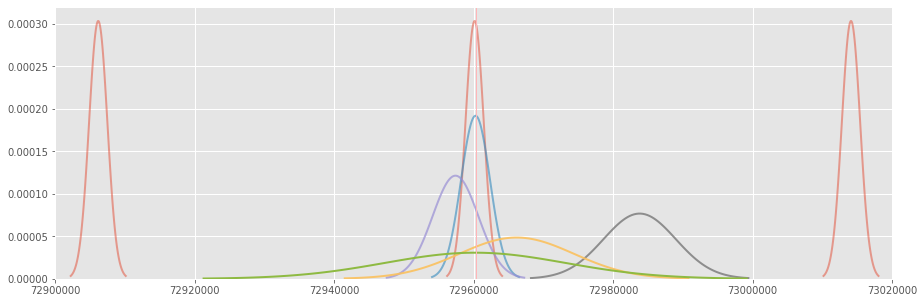

In [38]:
graficar_mediciones(zoom="Zona de interes")

Una vez que tenemos mediciones para cada minor tone, cada uno con un nivel de ambiguedad cada vez menor, se encuentra el punto en el que las mediciones de todos concuerdan en un valor, en nuestro caso, concuerdan con el doble del tiempo necesario para que la señal viaje de la antena en tierra al satelite.

A partir de este momento se empiezan las mediciones reales, las cuales mejorarán la precisión de la medición.

![](./diagrams/rng_screen.png)

Este proceso se puede monitorear desde EPOCH (Telemetry viewer y Event viewer), podemos mencionar los siguientes puntos:

* El archivo de calibración de tierra se menciona en la parte superior de esta imagen, este debe coincidir con la configuración de RF para que los archivos de rango sean generados con valores correctos.
* El valor de rango obtenido en la ultima secuencia de rango se despliega en valor de telemetría: **RNG_SEQ_AVERAGE_DISTANCE**.
* Los valores mínimos y máximos posibles se despliegan en valores de telemetría: **CRAU_MIN_DISTANCE** y **CRAU_MAX_DISTANCE**.
* El progreso de la secuencia de rango se despliega como histogramas con hasta 10 posibles secuencias de rango por evento, este valor se empieza a actualizar cuando comienzan las mediciones con el tono mayor.
* Se despliegan los valores P y Q tanto del tono mayor, como de los tonos menores de la secuencia de rango; estos valores son los necesarios para programar el cortex con nuevas frecuencias de tonos.
* Se despliegan el numero de mediciones que se realizan con cada tono; con los tonos menores solo se elimina la ambiguedad y con el tono mayor se realizan las 10 mediciones de la secuencia de rango.
* Se despliegan los valores de corrección de cada tono debido a la retransmisión por parte de la nave.
* Se despliega el nombre del estándar con el que se realizan las mediciones: **ESA_LIKE**.

```
SIGNATURE:     Epoch Track File
DESCRIPTION:   Raw Range Measurement File
FILE TYPE:     TRACKING
PATH:          /home/epochtc/output/mx3/ranging/rng_data/mx3_IZ3_202002252030.trk

SPACECRAFT:    mx3
STATION:       IZ3
PHASE TYPE:    LAG
TIME UNITS:    YmdHMs3

#TONE TYPE       : ESA-Like Standard
#RANGING TYPE    : Beacon Telemetry
#GND CAL FILENAME: /home/epochtc/output/mx3/ranging/gnd_cal/izm3tbbu1_rf_string1.cal
#RANGE SEED      : 0.000000 km
#BASEBAND        : izm3tbbu1


CALIBRATION:   IZ3

2020/02/25 20:30:36.000 RANGE     0.000000 KILOMETERS
# Set ground cal to zero. Correction in range values.


TRACKING DATA:

#Corrected Tracking Data:
2020/02/25 20:30:45.134  RANGE 36461.051414 KILOMETERS
2020/02/25 20:30:45.384  RANGE 36461.051264 KILOMETERS
2020/02/25 20:30:45.634  RANGE 36461.051714 KILOMETERS
2020/02/25 20:30:45.884  RANGE 36461.051714 KILOMETERS
2020/02/25 20:30:46.134  RANGE 36461.051864 KILOMETERS
2020/02/25 20:30:46.384  RANGE 36461.052463 KILOMETERS
2020/02/25 20:30:46.634  RANGE 36461.052463 KILOMETERS
2020/02/25 20:30:46.884  RANGE 36461.052014 KILOMETERS
2020/02/25 20:30:47.134  RANGE 36461.052164 KILOMETERS
2020/02/25 20:30:47.384  RANGE 36461.051864 KILOMETERS
#Quality Factor         :        +100.000000
#Baseband Raw Time Meas :  +121684688.100000 ns,      +36480.151746 km (one-way average)
#RAW_GND_CAL            :      +63710.250701 ns,         +19.099853 km (one-way average delay subtracted from baseband raw meas)
#Fully Corrected Range  :  +121620977.849299 ns,      +36461.051894 km (one-way average)
#Baseband Timetag       : 2020/02/25 20:30:45.134 (1582662645 sec 134000 usec)

2020/02/25 20:30:57.258  RANGE 36461.051564 KILOMETERS
2020/02/25 20:30:57.508  RANGE 36461.051714 KILOMETERS
2020/02/25 20:30:57.758  RANGE 36461.052613 KILOMETERS
2020/02/25 20:30:58.008  RANGE 36461.052463 KILOMETERS
2020/02/25 20:30:58.258  RANGE 36461.052164 KILOMETERS
2020/02/25 20:30:58.508  RANGE 36461.051564 KILOMETERS
2020/02/25 20:30:58.758  RANGE 36461.052463 KILOMETERS
2020/02/25 20:30:59.008  RANGE 36461.052164 KILOMETERS
2020/02/25 20:30:59.258  RANGE 36461.052314 KILOMETERS
2020/02/25 20:30:59.508  RANGE 36461.052763 KILOMETERS
#Quality Factor         :        +100.000000
#Baseband Raw Time Meas :  +121684689.050000 ns,      +36480.152031 km (one-way average)
#RAW_GND_CAL            :      +63710.250701 ns,         +19.099853 km (one-way average delay subtracted from baseband raw meas)
#Fully Corrected Range  :  +121620978.799299 ns,      +36461.052179 km (one-way average)
#Baseband Timetag       : 2020/02/25 20:30:57.258 (1582662657 sec 258000 usec)

```

Los valores de medición quedan asentados en archivos ubicados en izopsgs1, estos tienen un formato especifico y datos que informan al personal de Dinámica orbital la forma en que fueron generados para descartar incertidumbre en su calidad.

## Equipo (salida) 
### Configuración actual

Por ultimo, solo mencionar el equipo involucrado en la secuencia de rango.

* izopsfep1

* BBU1 [BBU2]

* UC1 [UCR]

* HPA1 [HPAR]

* Antenna Feeder

## Equipo (entrada)
### Configuración actual

Y de salida.

* Antenna Feeder

* [LNA1] LNA2 [LNA3]

* DC1
* DCR

* BBU1
* BBU2

In [34]:
%%file diagrams/diagrama_mx3
blockdiag {
    A [label = "izopsfep1"];
    B [label = "BBU1"];
    C [label = "UC1"];
    D [label = "HPA1"];
    E [label = "Antenna Feeder"];
    F [label = "Spacecraft"];
    
    I [label = "LNA2"];
    J [label = "DC1"];
    K [label = "DCR"];

    B -> C;
    C -> D;
    D -> E;
    E -> F [dir = "both"];
    
    A -> B [dir = "both"];
    B -> J [dir = "back"];
    B -> K [dir = "back"];
    J -> I [dir = "back"];
    K -> I [dir = "back"];
    I -> E [dir = "back"];
    
}

Overwriting diagrams/diagrama_mx3


In [35]:
!blockdiag --size=2000x1200 diagrams/diagrama_mx3

### En conclusión

![](./diagrams/diagrama_mx3.png)

# Gracias por su tiempo